In [1]:
# Built-in dependencies
import copy
from typing import Dict, List

# External dependencies
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta
from datetime import datetime as dt
from matplotlib import pyplot as plt

# Constants
NAV: float = 45_883.87
TRADING_DAYS: int = 10
VOLATILITY_TARGET: float = 0.20
TRADING_HOURS_PER_DAY: int = 7
TRADING_30_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 2
TRADING_5_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 12
SAMPLING_FREQUENCIES: List = ["1d", "1h", "30m", "5m"]
SHARPE_RATIO_ASSUMPTIONS: Dict = {
    "SPY": 0.2,
    "TLT": 0.1
}
SAMPLING_FREQUENCY_TO_TIME_UNITS_PER_DAY: Dict = {
    "1d": 1,
    "1h": TRADING_HOURS_PER_DAY,
    "30m": TRADING_30_MIN_PER_DAY,
    "5m": TRADING_5_MIN_PER_DAY
}
SAMPLING_FREQUENCY_TO_VARIANCE_ANNUALIZATION_MAP: Dict = {
        "1d": 252,
        "1h": TRADING_HOURS_PER_DAY * 252,
        "30m": TRADING_30_MIN_PER_DAY * 252,
        "5m": TRADING_5_MIN_PER_DAY * 252
}

In [2]:
def load_data(ticker: str) -> pd.DataFrame:

    daily: pd.Series = yf.download(tickers=ticker, interval="1d")["Close"].pct_change()
    hourly: pd.Series = yf.download(tickers=ticker, start=dt.today().date() + timedelta(days=-365), interval="1h")["Close"].pct_change()
    min_30: pd.Series = yf.download(tickers=ticker, start=dt.today().date() + timedelta(days=-30), interval="30m")["Close"].pct_change()
    min_5: pd.Series = yf.download(tickers=ticker, start=dt.today().date() + timedelta(days=-30), interval="5m")["Close"].pct_change()

    returns = pd.concat(
        [
            daily,
            hourly,
            min_30,
            min_5
        ],
        axis=1
    )
    returns.columns = SAMPLING_FREQUENCIES
    
    return returns


def calculate_ex_ante_volatility(returns: pd.DataFrame) -> pd.DataFrame:

    # Define lookback and halflife in terms of trading days
    lookback: int = 20
    halflife: int = int(TRADING_DAYS / 2)
    
    ex_ante_volatility: pd.DataFrame = pd.concat(
        [
            (returns["1d"].dropna().ewm(halflife=halflife).std().dropna() * np.sqrt(SAMPLING_FREQUENCY_TO_VARIANCE_ANNUALIZATION_MAP["1d"])).tail(lookback),
            (returns["1h"].dropna().ewm(halflife=halflife * SAMPLING_FREQUENCY_TO_TIME_UNITS_PER_DAY["1h"]).std().dropna() * np.sqrt(SAMPLING_FREQUENCY_TO_VARIANCE_ANNUALIZATION_MAP["1h"])).tail(lookback * TRADING_HOURS_PER_DAY),
            (returns["30m"].dropna().ewm(halflife=halflife * SAMPLING_FREQUENCY_TO_TIME_UNITS_PER_DAY["30m"]).std().dropna() * np.sqrt(SAMPLING_FREQUENCY_TO_VARIANCE_ANNUALIZATION_MAP["30m"])).tail(lookback * TRADING_30_MIN_PER_DAY),
            (returns["5m"].dropna().ewm(halflife=halflife * SAMPLING_FREQUENCY_TO_TIME_UNITS_PER_DAY["5m"]).std().dropna() * np.sqrt(SAMPLING_FREQUENCY_TO_VARIANCE_ANNUALIZATION_MAP["5m"])).tail(lookback * TRADING_5_MIN_PER_DAY)
        ],
        axis=1
    ).ffill()

    # Rename columns
    ex_ante_volatility.columns = SAMPLING_FREQUENCIES
    
    # Volatilty estimator is a simple sampling frequency ensemble
    ex_ante_volatility["mean"] = ex_ante_volatility.mean(axis=1)
    
    return ex_ante_volatility


def calculate_ex_ante_covariance_matrix(**returns) -> pd.DataFrame:

    # Define halflife in terms of trading days
    halflife: int = 20

    # Initialize covariance matrix map
    covariance_matrices: Dict = {}
    
    for sampling_frequency in SAMPLING_FREQUENCIES:

        # Initialize sampling frequency-specific returns map 
        sampling_frequency_returns: Dict = {}

        # Postprocess each ticker's returns and update sampling frequency-specific returns map
        for ticker in returns.keys():
            sampling_frequency_returns[ticker]: pd.Series = returns[ticker][sampling_frequency].dropna()
            
        sampling_frequency_returns: pd.DataFrame = pd.DataFrame(sampling_frequency_returns)
        
        # Calculate the exponentially weighted covariance matrix estimator - get the most recent covariance matrix estimator from multi-index object
        covariance_matrices[sampling_frequency]: pd.DataFrame = sampling_frequency_returns.ewm(
            halflife=halflife * SAMPLING_FREQUENCY_TO_TIME_UNITS_PER_DAY[sampling_frequency]
        ).cov().iloc[-2:] * SAMPLING_FREQUENCY_TO_VARIANCE_ANNUALIZATION_MAP[sampling_frequency]

    # Create an empty covariance matrix to later fill in - convert multi-index covariance matrix into a single pd.DataFrame
    index: pd.Timestamp = covariance_matrices["1d"].index[0][0]
    covariance_matrix: pd.DataFrame = copy.deepcopy(covariance_matrices[SAMPLING_FREQUENCIES[0]] * 0).loc[index]

    # For each sampling frequency, get its covariance matrix, and use it to construct an ensemble-based covariance matrix estimator
    for sampling_frequency in SAMPLING_FREQUENCIES:

        # Equally weight each sampling frequency's covariance matrix - convert multi-index covariance matrix into a single pd.DataFrame
        index: pd.Timestamp = covariance_matrices[sampling_frequency].index[0][0]
        covariance_matrix += covariance_matrices[sampling_frequency].loc[index] / len(SAMPLING_FREQUENCIES)

    # Return ensemble-based covariance estimator
    return covariance_matrix

Load data and calculate instrument-level ex ante volatilty 

In [3]:
returns_map: Dict = {}
ex_ante_volatility_map: Dict = {} 

for ticker in ("SPY", "TLT"):
    returns_map[ticker]: pd.DataFrame = load_data(ticker=ticker)
    ex_ante_volatility_map[ticker]: pd.DataFrame = calculate_ex_ante_volatility(returns=returns_map[ticker])

returns_map

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


{'SPY':                                  1d  1h  30m        5m
 1993-01-29 00:00:00+00:00       NaN NaN  NaN       NaN
 1993-02-01 00:00:00+00:00  0.007112 NaN  NaN       NaN
 1993-02-02 00:00:00+00:00  0.002119 NaN  NaN       NaN
 1993-02-03 00:00:00+00:00  0.010571 NaN  NaN       NaN
 1993-02-04 00:00:00+00:00  0.004184 NaN  NaN       NaN
 ...                             ...  ..  ...       ...
 2024-12-20 20:35:00+00:00       NaN NaN  NaN  0.002626
 2024-12-20 20:40:00+00:00       NaN NaN  NaN -0.000321
 2024-12-20 20:45:00+00:00       NaN NaN  NaN  0.000270
 2024-12-20 20:50:00+00:00       NaN NaN  NaN -0.001792
 2024-12-20 20:55:00+00:00       NaN NaN  NaN  0.000525
 
 [11533 rows x 4 columns],
 'TLT':                                  1d  1h  30m        5m
 2002-07-30 00:00:00+00:00       NaN NaN  NaN       NaN
 2002-07-31 00:00:00+00:00  0.012390 NaN  NaN       NaN
 2002-08-01 00:00:00+00:00  0.005695 NaN  NaN       NaN
 2002-08-02 00:00:00+00:00  0.010241 NaN  NaN       NaN
 2002

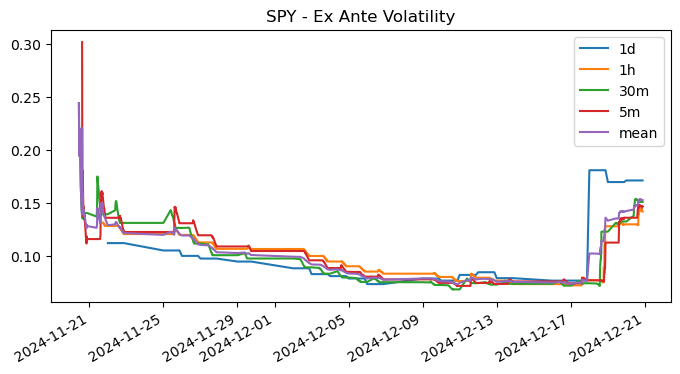

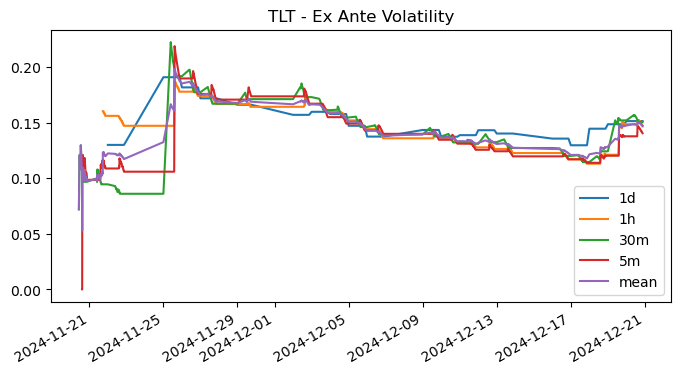

In [4]:
ex_ante_volatility_map["SPY"].plot(title="SPY - Ex Ante Volatility", figsize=(8, 4))
plt.show()

ex_ante_volatility_map["TLT"].plot(title="TLT - Ex Ante Volatility", figsize=(8, 4))
plt.show()

Calculate ex ante covariance matrix

In [6]:
covariance_matrix: pd.DataFrame = calculate_ex_ante_covariance_matrix(**returns_map)
covariance_matrix

,SPY,TLT
SPY,0.016147,0.001072
TLT,0.001072,0.021564


Calculate ex ante returns from assumed long-term SR and ex ante volatility estimates

In [7]:
ex_ante_returns: pd.Series = pd.Series(
    {
        "SPY": SHARPE_RATIO_ASSUMPTIONS["SPY"] * ex_ante_volatility_map["SPY"]["mean"].iloc[-1],
        "TLT": SHARPE_RATIO_ASSUMPTIONS["TLT"] * ex_ante_volatility_map["TLT"]["mean"].iloc[-1]
    }
)
ex_ante_returns

SPY    0.030588
TLT    0.014722
dtype: float64

Calculate optimal weights - this is consistent with linear utility optimization via max SR optimization + log utility optimization via volatility targeting (i.e., Kelly betting)

In [8]:
# Calculate max SR optimized weights
optimal_weights: pd.Series = pd.Series(np.dot(np.linalg.inv(covariance_matrix), ex_ante_returns), index=["SPY", "TLT"])

# Volatility scale weights
volatility_scalar: float = VOLATILITY_TARGET / np.sqrt(np.dot(np.dot(np.transpose(optimal_weights), covariance_matrix), optimal_weights)) 
optimal_weights = volatility_scalar * optimal_weights
optimal_weights

SPY    1.450414
TLT    0.461675
dtype: float64

Calculate optimal SPY vs. UPRO weights to target the optimal levered SPY exposure

In [9]:
"""
Solve: Ax = B

SPY Weight + UPRO Weight = (1 - TLT Weight)
SPY Weight * 1 + UPRO Weight * 3 = Target SPY Leverage

A = [
    [1, 1]
    [1, 3]
]

B = [
    [1 - TLT Weight]
    [Target SPY Leverage]
]

x = [
    [SPY Weight]
    [UPRO Weight]
]
"""

A = np.array(
    [
        [1, 1],
        [1, 3]
    ]
)
B = np.array(
    [
        [1 - optimal_weights.loc["TLT"]],
        [optimal_weights.loc["SPY"]]
    ]
)

spy_upro_optimal_weights: np.ndarray = np.linalg.solve(a=A, b=B)
spy_upro_optimal_weights: pd.Series = pd.Series({"SPY": spy_upro_optimal_weights[0][0], "UPRO": spy_upro_optimal_weights[1][0]})
spy_upro_optimal_weights

SPY     0.082281
UPRO    0.456044
dtype: float64

Calculate instrument-level optimal weights

In [10]:
optimal_weights: pd.Series = pd.Series(
    {
        "SPY": spy_upro_optimal_weights["SPY"],
        "UPRO": spy_upro_optimal_weights["UPRO"],
        "TLT": optimal_weights["TLT"]
    }
)

assert optimal_weights.sum() == 1.00

optimal_weights

SPY     0.082281
UPRO    0.456044
TLT     0.461675
dtype: float64

In [11]:
(optimal_weights * NAV).round(2)

SPY      3775.37
UPRO    20925.07
TLT     21183.43
dtype: float64